In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [47]:
train=pd.read_csv("blood-train.csv")
test=pd.read_csv("blood-test.csv")

In [48]:
train.shape

(576, 6)

In [49]:
test.shape

(200, 5)

In [50]:
df=pd.concat([train,test])

C:\Users\Hiesenberg_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [51]:
df.shape

(776, 6)

In [52]:
df.head()

,Made Donation in March 2007,Months since First Donation,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Unnamed: 0
0,1.0,98,2,50,12500,619
1,1.0,28,0,13,3250,664
2,1.0,35,1,16,4000,441
3,1.0,45,2,20,5000,160
4,0.0,77,1,24,6000,358


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 776 entries, 0 to 199
Data columns (total 6 columns):
Made Donation in March 2007    576 non-null float64
Months since First Donation    776 non-null int64
Months since Last Donation     776 non-null int64
Number of Donations            776 non-null int64
Total Volume Donated (c.c.)    776 non-null int64
Unnamed: 0                     776 non-null int64
dtypes: float64(1), int64(5)
memory usage: 42.4 KB


In [54]:
df.isnull().sum()

Made Donation in March 2007    200
Months since First Donation      0
Months since Last Donation       0
Number of Donations              0
Total Volume Donated (c.c.)      0
Unnamed: 0                       0
dtype: int64

In [55]:
df.fillna(0,inplace=True)

In [56]:
df.isnull().sum()

Made Donation in March 2007    0
Months since First Donation    0
Months since Last Donation     0
Number of Donations            0
Total Volume Donated (c.c.)    0
Unnamed: 0                     0
dtype: int64

In [57]:
df["Made Donation in March 2007"].value_counts()

0.0    638
1.0    138
Name: Made Donation in March 2007, dtype: int64

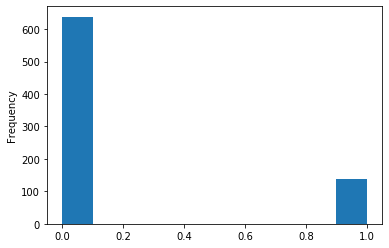

In [58]:
df["Made Donation in March 2007"].plot(kind='hist')

In [59]:
features=df.drop("Made Donation in March 2007",axis=1)
target=df["Made Donation in March 2007"]

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
x_train,x_test,y_train,y_test=train_test_split(features,target)

In [62]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

In [63]:
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(x_train, y_train)

Generation 1 - Current best internal CV score: 0.6998590225563911
Generation 2 - Current best internal CV score: 0.6998590225563911
Generation 3 - Current best internal CV score: 0.7065570175438596
Generation 4 - Current best internal CV score: 0.7065570175438596
Generation 5 - Current best internal CV score: 0.7065570175438596

Best pipeline: LogisticRegression(input_matrix, C=1.0, dual=False, penalty=l2)


TPOTClassifier(config_dict='TPOT light', crossover_rate=0.1, cv=5,
               disable_update_check=True, early_stop=None, generations=5,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=20,
               random_state=42, scoring='roc_auc', subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [64]:
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(x_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')


AUC score: 0.7564


In [65]:
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    print(f'{idx}. {transform}')


Best pipeline steps:
1. LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [66]:
x_train.var().round(3)

Months since First Donation        565.447
Months since Last Donation          67.418
Number of Donations                 33.667
Total Volume Donated (c.c.)    2104176.648
Unnamed: 0                       47250.029
dtype: float64

In [67]:
x_train_normed,x_test_normed = x_train.copy(), x_test.copy()

In [68]:
col_to_normalize = 'Total Volume Donated (c.c.)'

# Log normalization
for df_ in [x_train_normed, x_test_normed]:
    # Add log normalized column
    df_['monetary_log'] = np.log(df_[col_to_normalize])
    # Drop the original column
    df_.drop(columns=col_to_normalize, inplace=True)


In [69]:
x_train_normed.var().round(3)

Months since First Donation      565.447
Months since Last Donation        67.418
Number of Donations               33.667
Unnamed: 0                     47250.029
monetary_log                       0.831
dtype: float64

In [71]:
from sklearn.linear_model import LogisticRegression

In [72]:
logreg = LogisticRegression(solver='liblinear',random_state=42)

In [75]:
logreg.fit(x_train_normed,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
pred=logreg.predict(x_test_normed)

In [80]:
from sklearn.metrics import confusion_matrix

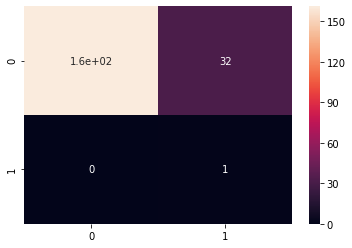

In [90]:
sns.heatmap(confusion_matrix(pred,y_test),annot=True)

In [78]:
logreg_auc_score = roc_auc_score(y_test, logreg.predict_proba(x_test_normed)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')


AUC score: 0.7683


In [82]:
from operator import itemgetter

In [83]:
sorted([('tpot', tpot_auc_score), ('logreg', logreg_auc_score)],key=itemgetter(1),reverse=True)

[('logreg', 0.7683041596085075), ('tpot', 0.756446452098626)]